In [1]:
#@title ##### License
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Physical dynamics of a mass-spring system
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the motion of a set of masses connected by springs.

The network is trained to predict the behaviour of a chain of five masses, connected by identical springs. The first and last masses are fixed; the others are subject to gravity.

After training, the network's prediction ability is illustrated by comparing its output to the true behaviour of the structure. Then the network's ability to generalise is tested, by using it to predict the behaviour of a similar but more complicated mass/spring structure.

In [2]:
#@title ### Install the Graph Nets library on this Colaboratory runtime  { form-width: "60%", run: "auto"}
#@markdown <br>1. Connect to a local or hosted Colaboratory runtime by clicking the **Connect** button at the top-right.<br>2. Choose "Yes" below to install the Graph Nets library on the runtime machine with the correct dependencies. Note, this works both with local and hosted Colaboratory runtimes.

install_graph_nets_library = "No"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


### Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"
```

# Code

In [3]:
#@title Imports  { form-width: "30%" }

# The demo dependencies are not installed with the library, but you can install
# them with:
#
# $ pip install jupyter matplotlib scipy
#
# Run the demo with:
#
# $ jupyter notebook <path>/<to>/<demos>/shortest_path.ipynb
#%tensorflow_version 1.x  # For Google Colab only.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets.demos import models
from matplotlib import pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf


try:
  import seaborn as sns
except ImportError:
  pass
else:
  sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [4]:
#@title Helper functions  { form-width: "30%" }

# pylint: disable=redefined-outer-name

def base_graph(n, d):
  """Define a basic mass-spring system graph structure.

  These are n masses (1kg) connected by springs in a chain-like structure. The
  first and last masses are fixed. The masses are vertically aligned at the
  start and are d meters apart; this is also the rest length for the springs
  connecting them. Springs have spring constant 50 N/m and gravity is 10 N in
  the negative y-direction.

  Args:
    n: number of masses
    d: distance between masses (as well as springs' rest length)

  Returns:
    data_dict: dictionary with globals, nodes, edges, receivers and senders
        to represent a structure like the one above.
  """
  # Nodes
  # Generate initial position and velocity for all masses.
  # The left-most mass has is at position (0, 0); other masses (ordered left to
  # right) have x-coordinate d meters apart from their left neighbor, and
  # y-coordinate 0. All masses have initial velocity 0m/s.
  nodes = np.zeros((n, 5), dtype=np.float32)
  half_width = d * n / 2.0
  nodes[:, 0] = np.linspace(
      -half_width, half_width, num=n, endpoint=False, dtype=np.float32)
  # indicate that the first and last masses are fixed
  nodes[(0, -1), -1] = 1.#nodes[(0, -1)] = 1.#

  # Edges.
  edges, senders, receivers = [], [], []
  for i in range(n - 1):
    left_node = i
    right_node = i + 1
    # The 'if' statements prevent incoming edges to fixed ends of the string.
    if right_node < n - 1:
      # Left incoming edge.
      edges.append([50., d])
      senders.append(left_node)
      receivers.append(right_node)
    if left_node > 0:
      # Right incoming edge.
      edges.append([50., d])
      senders.append(right_node)
      receivers.append(left_node)

  return {
      "globals": [0., -10.],
      "nodes": nodes,
      "edges": edges,
      "receivers": receivers,
      "senders": senders
  }


def hookes_law(receiver_nodes, sender_nodes, k, x_rest):
  """Applies Hooke's law to springs connecting some nodes.

  Args:
    receiver_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      receiver node of each edge.
    sender_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      sender node of each edge.
    k: Spring constant for each edge.
    x_rest: Rest length of each edge.

  Returns:
    Nx2 Tensor of the force [f_x, f_y] acting on each edge.
  """
  diff = receiver_nodes[..., 0:2] - sender_nodes[..., 0:2]
  x = tf.norm(diff, axis=-1, keepdims=True)
  force_magnitude = -1 * tf.multiply(k, (x - x_rest) / x)
  force = force_magnitude * diff
  return force


def euler_integration(nodes, force_per_node, step_size):
  """Applies one step of Euler integration.

  Args:
    nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each node.
    force_per_node: Ex2 tf.Tensor of the force [f_x, f_y] acting on each edge.
    step_size: Scalar.

  Returns:
    A tf.Tensor of the same shape as `nodes` but with positions and velocities
        updated.
  """
  is_fixed = nodes[..., 4:5]
  # set forces to zero for fixed nodes
  force_per_node *= 1 - is_fixed
  new_vel = nodes[..., 2:4] + force_per_node * step_size
  return new_vel


class SpringMassSimulator(snt.AbstractModule):
  """Implements a basic Physics Simulator using the blocks library."""

  def __init__(self, step_size, name="SpringMassSimulator"):
    super(SpringMassSimulator, self).__init__(name=name)
    self._step_size = step_size

    with self._enter_variable_scope():
      self._aggregator = blocks.ReceivedEdgesToNodesAggregator(
          reducer=tf.unsorted_segment_sum)

  def _build(self, graph):
    """Builds a SpringMassSimulator.

    Args:
      graph: A graphs.GraphsTuple having, for some integers N, E, G:
          - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each
            edge.
          - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
            node.
          - globals: Gx2 tf.Tensor containing the gravitational constant.

    Returns:
      A graphs.GraphsTuple of the same shape as `graph`, but where:
          - edges: Holds the force [f_x, f_y] acting on each edge.
          - nodes: Holds positions and velocities after applying one step of
              Euler integration.
    """
    receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
    sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)

    spring_force_per_edge = hookes_law(receiver_nodes, sender_nodes,
                                       graph.edges[..., 0:1],
                                       graph.edges[..., 1:2])
    graph = graph.replace(edges=spring_force_per_edge)

    spring_force_per_node = self._aggregator(graph)
    gravity = blocks.broadcast_globals_to_nodes(graph)
    updated_velocities = euler_integration(
        graph.nodes, spring_force_per_node + gravity, self._step_size)
    graph = graph.replace(nodes=updated_velocities)
    return graph


def prediction_to_next_state(input_graph, predicted_graph, step_size):
  # manually integrate velocities to compute new positions
  new_pos = input_graph.nodes[..., :2] + predicted_graph.nodes * step_size
  new_nodes = tf.concat(
      [new_pos, predicted_graph.nodes, input_graph.nodes[..., 4:5]], axis=-1)
  return input_graph.replace(nodes=new_nodes)


def roll_out_physics(simulator, graph, steps, step_size):
  """Apply some number of steps of physical laws to an interaction network.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: A graphs.GraphsTuple having, for some integers N, E, G:
        - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each edge.
        - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
          node.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: An integer.
    step_size: Scalar.

  Returns:
    A pair of:
    - The graph, updated after `steps` steps of simulation;
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """

  def body(t, graph, nodes_per_step):
    predicted_graph = simulator(graph)
    if isinstance(predicted_graph, list):
      predicted_graph = predicted_graph[-1]
    graph = prediction_to_next_state(graph, predicted_graph, step_size)
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  return g, nodes_per_step.stack()


def apply_noise(graph, node_noise_level, edge_noise_level, global_noise_level):
  """Applies uniformly-distributed noise to a graph of a physical system.

  Noise is applied to:
  - the x and y coordinates (independently) of the nodes;
  - the spring constants of the edges;
  - the y coordinate of the global gravitational constant.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    The input graph, but with noise applied.
  """
  node_position_noise = tf.random_uniform(
      [graph.nodes.shape[0].value, 2],
      minval=-node_noise_level,
      maxval=node_noise_level)
  edge_spring_constant_noise = tf.random_uniform(
      [graph.edges.shape[0].value, 1],
      minval=-edge_noise_level,
      maxval=edge_noise_level)
  global_gravity_y_noise = tf.random_uniform(
      [graph.globals.shape[0].value, 1],
      minval=-global_noise_level,
      maxval=global_noise_level)

  return graph.replace(
      nodes=tf.concat(
          [graph.nodes[..., :2] + node_position_noise, graph.nodes[..., 2:]],
          axis=-1),
      edges=tf.concat(
          [
              graph.edges[..., :1] + edge_spring_constant_noise,
              graph.edges[..., 1:]
          ],
          axis=-1),
      globals=tf.concat(
          [
              graph.globals[..., :1],
              graph.globals[..., 1:] + global_gravity_y_noise
          ],
          axis=-1))


def set_rest_lengths(graph):
  """Computes and sets rest lengths for the springs in a physical system.

  The rest length is taken to be the distance between each edge's nodes.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.

  Returns:
    The input graph, but with [spring_constant, rest_length] for each edge.
  """
  receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
  sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)
  rest_length = tf.norm(
      receiver_nodes[..., :2] - sender_nodes[..., :2], axis=-1, keepdims=True)
  return graph.replace(
      edges=tf.concat([graph.edges[..., :1], rest_length], axis=-1))


def generate_trajectory(simulator, graph, steps, step_size, node_noise_level,
                        edge_noise_level, global_noise_level):
  """Applies noise and then simulates a physical system for a number of steps.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, v_x, v_y, is_fixed] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: Integer; the length of trajectory to generate.
    step_size: Scalar.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    A pair of:
    - The input graph, but with rest lengths computed and noise applied.
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """
  graph = apply_noise(graph, node_noise_level, edge_noise_level,
                      global_noise_level)
  graph = set_rest_lengths(graph)
  _, n = roll_out_physics(simulator, graph, steps, step_size)
  return graph, n


def create_loss_ops(target_op, output_ops):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
  """
  
  loss_ops = [
      tf.reduce_mean(
          tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1))
      for output_op in output_ops
  ]
      
  return loss_ops


def make_all_runnable_in_session(*args):
  """Apply make_runnable_in_session to an iterable of graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]


# pylint: enable=redefined-outer-name

In [5]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input mass-spring systems are
# procedurally generated, where the nodes represent the positions, velocities,
# and indicators of whether the mass is fixed in space or free to move, the
# edges represent the spring constant and spring rest length, and the global
# attribute represents the variable coefficient of gravitational acceleration.
# The outputs/targets have the same structure, with the nodes representing the
# masses' next-step states.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to systems which are one mass
# larger, and smaller, than those from the training distribution. The loss is
# computed as the mean over a 50-step rollout, where each step's input is the
# the previous step's output.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 10000-20000 training iterations the model reaches good
# performance on mass-spring systems with 5-8 masses.

tf.reset_default_graph()

rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 5#1
num_processing_steps_ge = 5#1

# Data / training parameters.
num_training_iterations = 100000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50
step_size = 0.1
num_masses_min_max_tr = (5, 9)
dist_between_masses_min_max_tr = (0.2, 1.0)

# Create the model.
model = models.EncodeProcessDecode(node_output_size=2)

# Data.
# Base graphs for training.
num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
dist_between_masses_tr = rand.uniform(
    *dist_between_masses_min_max_tr, size=batch_size_tr)
static_graph_tr = [
    base_graph(n, d) for n, d in zip(num_masses_tr, dist_between_masses_tr)
]
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)
# Base graphs for testing.
# 4 masses 1m apart in a chain like structure.
base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(4, 0.5)] * batch_size_ge)
# 9 masses 0.5m apart in a chain like structure.
base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(9, 0.5)] * batch_size_ge)
# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=step_size)
# Training.
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
# Random start step.
t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]
output_ops_tr = model(input_graph_tr, num_processing_steps_tr)
# Test data: 4-mass string.
initial_conditions_4_ge, true_trajectory_4_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
_, true_nodes_rollout_4_ge = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_4_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,
    num_time_steps, step_size)
# Test data: 9-mass string.
initial_conditions_9_ge, true_trajectory_9_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_9_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
_, true_nodes_rollout_9_ge = roll_out_physics(
    simulator, initial_conditions_9_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_9_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_9_ge,
    num_time_steps, step_size)

# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss: 4-mass.
loss_op_4_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_4_ge[..., 2:4] -
         true_nodes_rollout_4_ge[..., 2:4])**2,
        axis=-1))
# Test/generalization loss: 9-mass string.
loss_op_9_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_9_ge[..., 2:4] -
         true_nodes_rollout_9_ge[..., 2:4])**2,
        axis=-1))

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

input_graph_tr = make_all_runnable_in_session(input_graph_tr)
initial_conditions_4_ge = make_all_runnable_in_session(initial_conditions_4_ge)
initial_conditions_9_ge = make_all_runnable_in_session(initial_conditions_9_ge)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_4_ge = []
losses_9_ge = []

In [ ]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lge4 (test/generalization rollout loss for 4-mass strings), "
      "Lge9 (test/generalization rollout loss for 9-mass strings)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  train_values = sess.run({
      "step": step_op,
      "loss": loss_op_tr,
      "input_graph": input_graph_tr,
      "target_nodes": target_nodes_tr,
      "outputs": output_ops_tr
  })
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    test_values = sess.run({
        "loss_4": loss_op_4_ge,
        "true_rollout_4": true_nodes_rollout_4_ge,
        "predicted_rollout_4": predicted_nodes_rollout_4_ge,
        "loss_9": loss_op_9_ge,
        "true_rollout_9": true_nodes_rollout_9_ge,
        "predicted_rollout_9": predicted_nodes_rollout_9_ge
    })
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    losses_4_ge.append(test_values["loss_4"])
    losses_9_ge.append(test_values["loss_9"])
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge4 {:.4f}, Lge9 {:.4f}".format(
        iteration, elapsed, train_values["loss"], test_values["loss_4"],
        test_values["loss_9"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lge4 (test/generalization rollout loss for 4-mass strings), Lge9 (test/generalization rollout loss for 9-mass strings)
# 00536, T 21.4, Ltr 1.2216, Lge4 2.5943, Lge9 12.3823


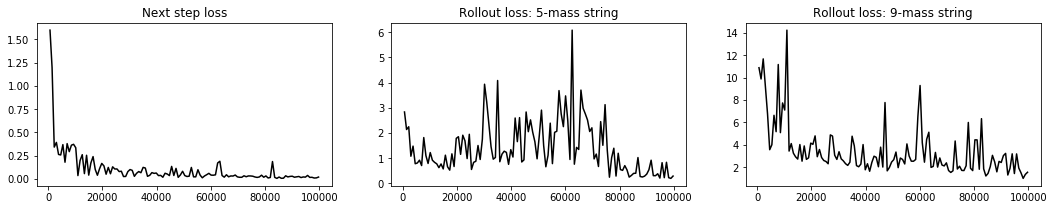

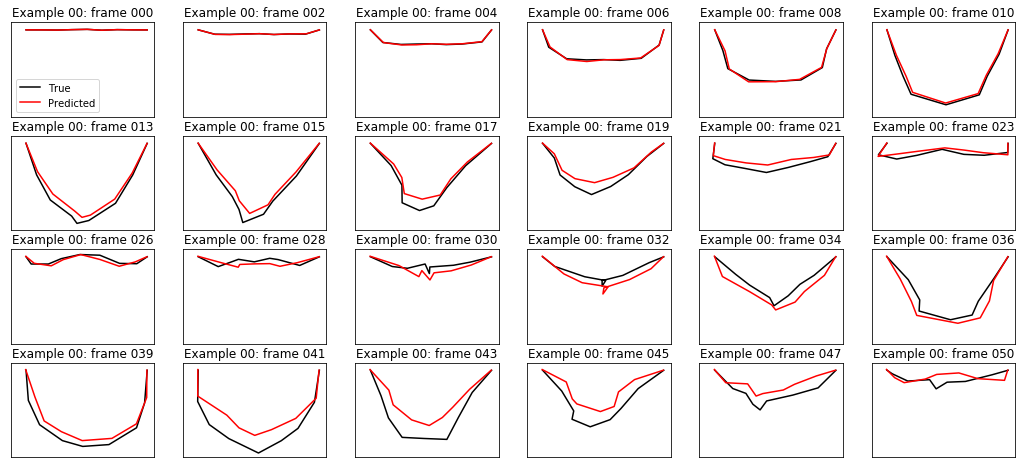

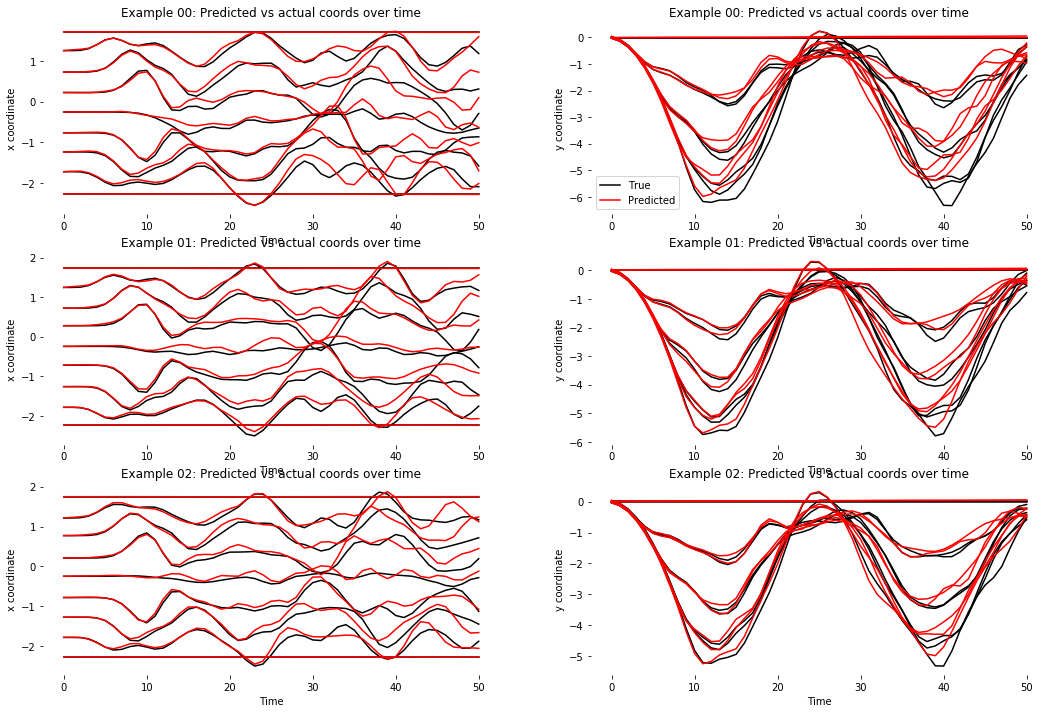

In [34]:
#@title Visualize loss curves  { form-width: "30%" }

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  return np.split(rollout_array[..., :2], batch_size, axis=1)


fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")
# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 5-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")

# Visualize trajectories.
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],
                                        batch_size_ge)
predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],
                                             batch_size_ge)
true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],
                                        batch_size_ge)
predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],
                                             batch_size_ge)

true_rollouts = true_rollouts_4
predicted_rollouts = predicted_rollouts_4
true_rollouts = true_rollouts_9
predicted_rollouts = predicted_rollouts_9

num_graphs = len(true_rollouts)
num_time_steps = true_rollouts[0].shape[0]

# Plot state sequences.
max_graphs_to_plot = 1
num_graphs_to_plot = min(num_graphs, max_graphs_to_plot)
num_steps_to_plot = 24
max_time_step = num_time_steps - 1
step_indices = np.floor(np.linspace(0, max_time_step,
                                    num_steps_to_plot)).astype(int).tolist()
w = 6
h = int(np.ceil(num_steps_to_plot / w))
fig = plt.figure(101, figsize=(18, 8))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  xys = np.hstack([predicted_rollout, true_rollout]).reshape([-1, 2])
  xs = xys[:, 0]
  ys = xys[:, 1]
  b = 0.05
  xmin = xs.min() - b * xs.ptp()
  xmax = xs.max() + b * xs.ptp()
  ymin = ys.min() - b * ys.ptp()
  ymax = ys.max() + b * ys.ptp()
  if i >= num_graphs_to_plot:
    break
  for j, step_index in enumerate(step_indices):
    iax = i * w + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(
        true_rollout[step_index, :, 0],
        true_rollout[step_index, :, 1],
        "k",
        label="True")
    ax.plot(
        predicted_rollout[step_index, :, 0],
        predicted_rollout[step_index, :, 1],
        "r",
        label="Predicted")
    ax.set_title("Example {:02d}: frame {:03d}".format(i, step_index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.legend(loc=3)

# Plot x and y trajectories over time.
max_graphs_to_plot = 3
num_graphs_to_plot = min(len(true_rollouts), max_graphs_to_plot)
w = 2
h = num_graphs_to_plot
fig = plt.figure(102, figsize=(18, 12))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  if i >= num_graphs_to_plot:
    break
  t = np.arange(num_time_steps)
  for j in range(2):
    coord_string = "x" if j == 0 else "y"
    iax = i * 2 + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(t, true_rollout[..., j], "k", label="True")
    ax.plot(t, predicted_rollout[..., j], "r", label="Predicted")
    ax.set_xlabel("Time")
    ax.set_ylabel("{} coordinate".format(coord_string))
    ax.set_title("Example {:02d}: Predicted vs actual coords over time".format(
        i))
    ax.set_frame_on(False)
    if i == 0 and j == 1:
      handles, labels = ax.get_legend_handles_labels()
      unique_labels = []
      unique_handles = []
      for i, (handle, label) in enumerate(zip(handles, labels)):  # pylint: disable=redefined-outer-name
        if label not in unique_labels:
          unique_labels.append(label)
          unique_handles.append(handle)
      ax.legend(unique_handles, unique_labels, loc=3)